# New York City Taxi Demand Forecast Project #
In New York City, taxi has always been one of the main way to travel accross the entire city. Hence, it is important to deep dive into the demand data and understand the trend, seasonality, and patterns. The ultimate goal of this project is to create an effective time series forecasting model to forecast future demand.   


### Data Source ###
In this project, the dataset comes from Kaggle. The link to the database is attached below. Within the dataset, we had information about every taxi trip that happened and started in NYC from 2016/01/01 to 2016/03/31. In general, there are 19 columns within the data frame. The data includes information, such as **taxi pickup datetime, taxi dropoff datetime, number of customers, toll fee, total amount of the trip, total distance of the trip**, and so on.
https://www.kaggle.com/datasets/vishnurapps/newyork-taxi-demand

### Project Overview ###
In this project, I will aggregate the data to hourly level. In the end, I will create an hourly time series forecasting model. As for modeling techniques, in this project, **I will try esemble models, such as ARIMA+PROPHET, ARIMA+LSTM, and LSTM+Prophet**. In addition, I will also try time-based cross-validation techniques.

### Data Preprocessing: clean data and drop unuseful columns ###

In [19]:
import pandas as pd
import numpy as np
import datetime as dt
import os
os.getcwd()
os.chdir('/Users/haochunniu/Desktop/Kaggle Compatition/NY Taxi Demand forecast/Raw Data')

In [10]:
#Read in the data
Jan=pd.read_csv('yellow_tripdata_2016-01.csv')
Jan=Jan.sort_values(by='tpep_pickup_datetime')
Jan.head(10)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2016-01-01 00:00:00,2016-01-01 00:00:00,2,1.10,-73.990372,40.734695,1,N,-73.981842,40.732407,2,7.5,0.5,0.5,0.0,0.0,0.3,8.8
1,2,2016-01-01 00:00:00,2016-01-01 00:00:00,5,4.90,-73.980782,40.729912,1,N,-73.944473,40.716679,1,18.0,0.5,0.5,0.0,0.0,0.3,19.3
2,2,2016-01-01 00:00:00,2016-01-01 00:00:00,1,10.54,-73.984550,40.679565,1,N,-73.950272,40.788925,1,33.0,0.5,0.5,0.0,0.0,0.3,34.3
3,2,2016-01-01 00:00:00,2016-01-01 00:00:00,1,4.75,-73.993469,40.718990,1,N,-73.962242,40.657333,2,16.5,0.0,0.5,0.0,0.0,0.3,17.3
4,2,2016-01-01 00:00:00,2016-01-01 00:00:00,3,1.76,-73.960625,40.781330,1,N,-73.977264,40.758514,2,8.0,0.0,0.5,0.0,0.0,0.3,8.8
5,2,2016-01-01 00:00:00,2016-01-01 00:18:30,2,5.52,-73.980118,40.743050,1,N,-73.913490,40.763142,2,19.0,0.5,0.5,0.0,0.0,0.3,20.3
6,2,2016-01-01 00:00:00,2016-01-01 00:26:45,2,7.45,-73.994057,40.719990,1,N,-73.966362,40.789871,2,26.0,0.5,0.5,0.0,0.0,0.3,27.3
7,1,2016-01-01 00:00:01,2016-01-01 00:11:55,1,1.20,-73.979424,40.744614,1,N,-73.992035,40.753944,2,9.0,0.5,0.5,0.0,0.0,0.3,10.3
8,1,2016-01-01 00:00:02,2016-01-01 00:11:14,1,6.00,-73.947151,40.791046,1,N,-73.920769,40.865578,2,18.0,0.5,0.5,0.0,0.0,0.3,19.3
9,2,2016-01-01 00:00:02,2016-01-01 00:11:08,1,3.21,-73.998344,40.723896,1,N,-73.995850,40.688400,2,11.5,0.5,0.5,0.0,0.0,0.3,12.8


In [7]:
#Check for NA values: None of the columns contain NA
#Jan.isnull().sum()

In [14]:
#Fix the timestamp datatype for pickup and dropoff datetime
Jan['tpep_pickup_datetime']=pd.to_datetime(Jan['tpep_pickup_datetime'])
Jan['tpep_dropoff_datetime']=pd.to_datetime(Jan['tpep_dropoff_datetime'])

In [27]:
#Because I am doing hourly forecast, I round all the pickup datetime to the nearest hour
Jan['tpep_pickup_datetime']=Jan['tpep_pickup_datetime'].dt.round('H')
Jan['tpep_dropoff_datetime']=Jan['tpep_dropoff_datetime'].dt.round('H')


In [86]:
#Group by the data with the pickup time stamp and use size the find the total trip each hour
Jan_cnt=Jan.groupby('tpep_pickup_datetime').size()
Jan_cnt=Jan_cnt.to_frame()
Jan_cnt.columns=['cnt']

In [87]:
#Given that I am not sure if there's gap among the time series, I will create a consecutive time series form 2016-01-01 00:00:00 to 2016-02-01 00:00:00
#Next, I will join the Jan_cnt back to consecutive time series created and fill all NA values with 0
frame=pd.DataFrame(index=pd.date_range(min(Jan['tpep_pickup_datetime']),
                                       max(Jan['tpep_pickup_datetime']),
                                       freq='H'))
Jan_cnt=frame.merge(Jan_cnt,left_index=True,right_index=True)

In [85]:
##Repeat all the steps above for 2016 Feb data

#Read in the data
Feb=pd.read_csv('yellow_tripdata_2016-02.csv')
Feb=Feb.sort_values(by='tpep_pickup_datetime')

#Fix the timestamp datatype for pickup and dropoff datetime
Feb['tpep_pickup_datetime']=pd.to_datetime(Feb['tpep_pickup_datetime'])
Feb['tpep_dropoff_datetime']=pd.to_datetime(Feb['tpep_dropoff_datetime'])

#Because I am doing hourly forecast, I round all the pickup datetime to the nearest hour
Feb['tpep_pickup_datetime']=Feb['tpep_pickup_datetime'].dt.round('H')
Feb['tpep_dropoff_datetime']=Feb['tpep_dropoff_datetime'].dt.round('H')

#Group by the data with the pickup time stamp and use size the find the total trip each hour
Feb_cnt=Feb.groupby('tpep_pickup_datetime').size()
Feb_cnt=Feb_cnt.to_frame()
Feb_cnt.columns=['cnt']

#Given that I am not sure if there's gap among the time series, I will create a consecutive time series form 2016-02-01 00:00:00 to 2016-03-01 00:00:00
#Next, I will join the Feb_cnt back to consecutive time series created and fill all NA values with 0
frame=pd.DataFrame(index=pd.date_range(min(Feb['tpep_pickup_datetime']),
                                       max(Feb['tpep_pickup_datetime']),
                                       freq='H'))
Feb_cnt=frame.merge(Feb_cnt,left_index=True,right_index=True)

In [81]:
##Repeat all the steps above for 2016 March data

#Read in the data
Mar=pd.read_csv('yellow_tripdata_2016-03.csv')
Mar=Mar.sort_values(by='tpep_pickup_datetime')

#Fix the timestamp datatype for pickup and dropoff datetime
Mar['tpep_pickup_datetime']=pd.to_datetime(Mar['tpep_pickup_datetime'])
Mar['tpep_dropoff_datetime']=pd.to_datetime(Mar['tpep_dropoff_datetime'])

#Because I am doing hourly forecast, I round all the pickup datetime to the nearest hour
Mar['tpep_pickup_datetime']=Mar['tpep_pickup_datetime'].dt.round('H')
Mar['tpep_dropoff_datetime']=Mar['tpep_dropoff_datetime'].dt.round('H')

#Group by the data with the pickup time stamp and use size the find the total trip each hour
Mar_cnt=Mar.groupby('tpep_pickup_datetime').size()
Mar_cnt=Mar_cnt.to_frame()
Mar_cnt.columns=['cnt']

#Given that I am not sure if there's gap among the time series, I will create a consecutive time series form 2016-03-01 00:00:00 to 2016-04-01 00:00:00
#Next, I will join the Feb_cnt back to consecutive time series created and fill all NA values with 0
frame=pd.DataFrame(index=pd.date_range(min(Mar['tpep_pickup_datetime']),
                                       max(Mar['tpep_pickup_datetime']),
                                       freq='H'))
Mar_cnt=frame.merge(Mar_cnt,left_index=True,right_index=True)

In [91]:
#Merge all three months data into one single data frame
#Given that the first days of Feb and Mar are overlapped, we need to sum those days' counts up.
Jan_cnt=Jan_cnt.reset_index()
Feb_cnt=Feb_cnt.reset_index()
Mar_cnt=Mar_cnt.reset_index()
All_cnt=pd.concat([Jan_cnt,Feb_cnt,Mar_cnt])
All_cnt=All_cnt.groupby('index').agg({'cnt':'sum'})
#All_cnt.to_csv('2016_Jan-Mar_Time_Series.csv')

### EDA: Time Series Plotting ###

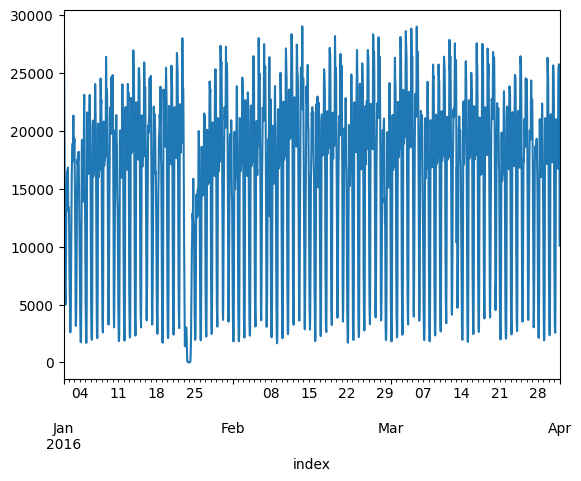

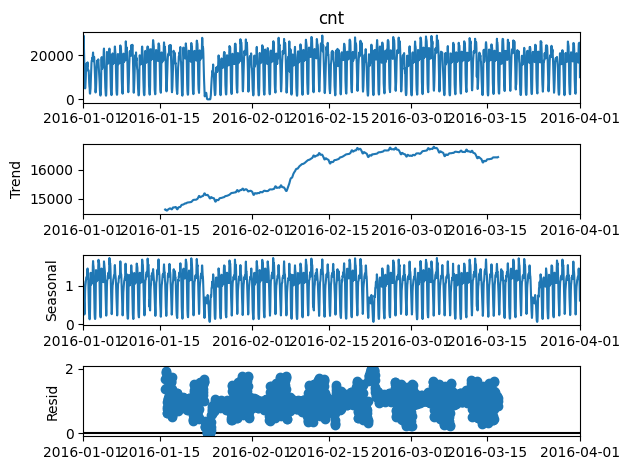

In [113]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

decom_plot=seasonal_decompose(All_cnt['cnt'], model='multiplicative',period=30*24)
All_cnt['cnt'].plot()
decom_plot.plot()
print()